In [100]:
import math
import os
import cv2
import numpy as np
from PIL import Image
from enum import Enum
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy.signal import savgol_filter


In [9]:
%pip install sklearn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'error'
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  Getting requirements to build wheel did not run successfully.
  exit code: 1
  
  [15 lines of output]
  The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
  rather than 'sklearn' for pip commands.
  
  Here is how to fix this error in the main use cases:
  - use 'pip install scikit-learn' rather than 'pip install sklearn'
  - replace 'sklearn' by 'scikit-learn' in your pip requirements files
    (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
  - if the 'sklearn' package is used by one of your dependencies,
    it would be great if you take some time to track which package uses
    'sklearn' instead of 'scikit-learn' and report it to their issue tracker
  - as a last resort, set the environment variable
    SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
  
  More information is available at
  https://github.com/scikit-learn/sklearn-pypi-package
  [end of output]
  
  note: This error originates f

In [180]:
def zero_pad(Y):
    mx, my = Y.shape
    padded_x = ((mx + 7) // 8) * 8
    padded_y = ((my + 7) // 8) * 8
    img = np.zeros((padded_x, padded_y), dtype=np.uint8)
    img[:mx, :my] = Y

    return img

def DCT(img):
    w, h = img.shape
    num_blocks = (w // 8) * (h // 8)
    dct_output = np.zeros((8, 8, num_blocks), dtype=float)

    for ci, (i, j) in enumerate((x, y) for x in range(0, w, 8) for y in range(0, h, 8)):
        dct_output[:, :, ci] = cv2.dct(img[i:i+8, j:j+8].astype(np.float32))  # Ensure input is float for DCT

    return dct_output


def hist(DC, N=2000, show=False):
    hcount, bin_edges = np.histogram(DC, bins=N, density=True)
    if show:
        plt.figure(figsize=(10, 6))
        sns.histplot(x=bin_edges[:-1], weights=hcount, bins=N, kde=True, stat="density")
        plt.title("DC Coefficient Histogram")
        plt.xlabel("DC Coefficient Value")
        plt.ylabel("Density")
        plt.show()
    return hcount, bin_edges

def FFT(hcount):
  hcount -= np.mean(hcount)
  x = np.fft.fft(hcount.astype(float))
  x = abs(np.fft.fftshift(x))
  x = savgol_filter(x, 11, 2)
  return x


# class QualityLevel(Enum):
#     ORIGINAL=100
#     #HIGH=np.random.randint(65,90)
#     HIGH=90
#     #MEDIUM=np.random.randint(35, 65)
#     MEDIUM=50
#     #WORST=np.random.randint(10,35)
#     WORST=10

def compress(path, quality=100):
    img = Image.open(path)
    img = img.convert('RGB')
    img.save('temp_jpeg.jpg',quality = quality)
    img = Image.open("temp_jpeg.jpg")
    img.save("temp_png.png")
    return Image.open("temp_png.png")

def quality(x, N=2000):
    ref = np.max(x)*0.12+np.mean(x)
    #ref += 0.065
    peaks, _ = find_peaks(x, height=ref, distance=15)
    uncompressed = False
    avg_dist = 0
    if len(peaks) <= 1:
        uncompressed = True
    else:
        distances = np.diff(peaks)
        avg_dist = np.bincount(distances).argmax()

    #print("Most Frequent Distance:", avg_dist if len(peaks) > 1 else "N/A")
    return uncompressed, avg_dist, peaks


(False, np.int64(554), array([ 446, 1000, 1554]))


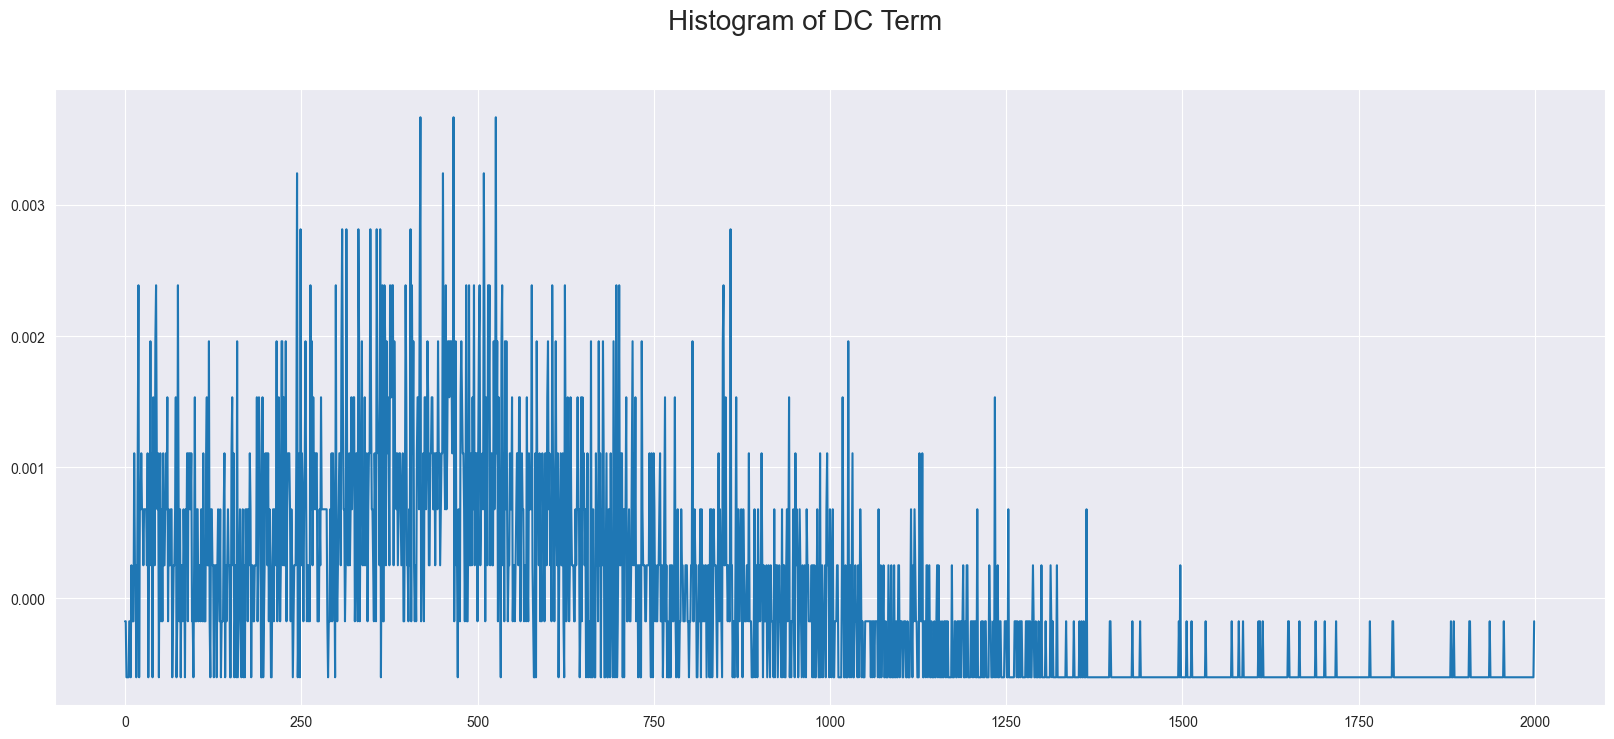

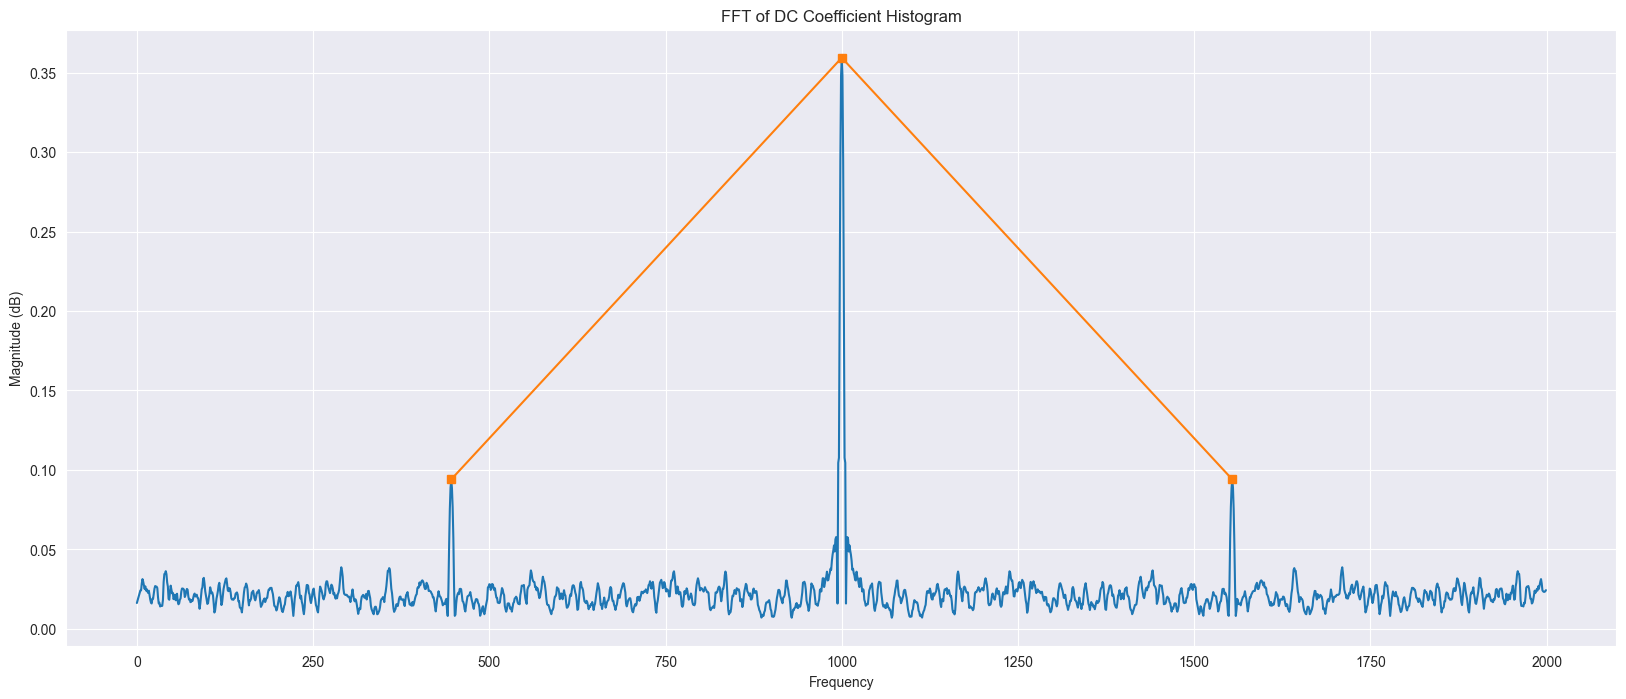

In [181]:
# Generating training data
uncompressed_data = []
quality_high = []
quality_medium = []
quality_low = []

image_number = 50 # 800 to account for the fact that it's counting from 1

for i in range(0, image_number):
    for j in range(1, 5):              # each image has 4 versions
        file_name = f"{i + 1:04}x4w{j}.png"
        path = os.path.join("./DIV2K_train_LR_wild", file_name)
        
        img = compress(path, QualityLevel.ORIGINAL)

        img = img.convert('YCbCr')
        img = zero_pad(np.array(img)[:,:,0])
        img = img.astype(np.float64)
        dct = DCT(img)[0,0,:]
        hcount, bin_edges = hist(dct)
        fft = FFT(hcount)
        _, avg_peak_dist = quality(fft)
        uncompressed_data.append(avg_peak_dist)
        
# High-quality images
for i in range(0, image_number):
    for j in range(1, 5):
        file_name = f"{i + 1:04}x4w{j}.png"
        
        path = os.path.join("DIV2K_train_LR_wild", file_name)
        
        img = compress(path, QualityLevel.HIGH)
        img = img.convert('YCbCr')
        img = zero_pad(np.array(img)[:,:,0])
        img = img.astype(np.float64)
        dct = DCT(img)[0,0,:]
        hcount, bin_edges = hist(dct)
        fft = FFT(hcount)
        _, avg_peak_dist = quality(fft)
        quality_high.append(avg_peak_dist)

# Medium-quality images
for i in range(0, image_number):
    for j in range(1, 5):
        file_name = f"{i + 1:04}x4w{j}.png"
        path = os.path.join("DIV2K_train_LR_wild", file_name)
        
        img = compress(path, QualityLevel.MEDIUM)
        img = img.convert('YCbCr')
        img = zero_pad(np.array(img)[:,:,0])
        img = img.astype(np.float64)
        dct = DCT(img)[0,0,:]
        hcount, bin_edges = hist(dct)
        fft = FFT(hcount)
        _, avg_peak_dist = quality(fft)
        quality_medium.append(avg_peak_dist)

img = compress("DIV2K_train_LR_wild/0001x4w1.png", 90)
img = img.convert('YCbCr')
img = zero_pad(np.array(img)[:,:,0])
img = img.astype(np.float64)
dct = DCT(img)[0,0,:]
hcount, bin_edges = hist(dct)
fft = FFT(hcount)
print(quality(fft))

_,_,peaks= quality(fft)

fig = plt.figure(figsize=(20,8))
plt.plot(hcount)
fig.suptitle("Histogram of DC Term",fontsize=20)


plt.figure(figsize=(20, 8))
plt.plot(fft)
plt.plot(peaks, fft[peaks], marker='s')
plt.title("FFT of DC Coefficient Histogram")
plt.xlabel("Frequency")
plt.ylabel("Magnitude (dB)")
plt.show()

In [200]:
# Generating training data
uncompressed_data = []
quality_high = []
quality_medium = []
quality_low = []

image_number = 800 # 800 to account for the fact that it's counting from 1
quality_peak_list=[]

for q in range(10,101,10):
    l=[]
    print(q)
    for i in range(0, image_number):
        for j in range(1, 2):              # each image has 4 versions
            file_name = f"{i + 1:04}x4w{j}.png"
            path = os.path.join("./DIV2K_train_LR_wild", file_name)
            
            img = compress(path, q)
    
            img = img.convert('YCbCr')
            img = zero_pad(np.array(img)[:,:,0])
            img = img.astype(np.float64)
            dct = DCT(img)[0,0,:]
            hcount, bin_edges = hist(dct)
            fft = FFT(hcount)
            _, avg_peak_dist,_ = quality(fft)
            l.append(avg_peak_dist)
    quality_peak_list.append(l)
        
# # High-quality images
# for i in range(0, image_number):
#     for j in range(1, 2):
#         file_name = f"{i + 1:04}x4w{j}.png"
#         
#         path = os.path.join("DIV2K_train_LR_wild", file_name)
#         
#         img = compress(path, QualityLevel.HIGH)
#         img = img.convert('YCbCr')
#         img = zero_pad(np.array(img)[:,:,0])
#         img = img.astype(np.float64)
#         dct = DCT(img)[0,0,:]
#         hcount, bin_edges = hist(dct)
#         fft = FFT(hcount)
#         _, avg_peak_dist,_ = quality(fft)
#         quality_high.append(avg_peak_dist)
# 
# # Medium-quality images
# for i in range(0, image_number):
#     for j in range(1, 2):
#         file_name = f"{i + 1:04}x4w{j}.png"
#         path = os.path.join("DIV2K_train_LR_wild", file_name)
#         
#         img = compress(path, QualityLevel.MEDIUM)
#         img = img.convert('YCbCr')
#         img = zero_pad(np.array(img)[:,:,0])
#         img = img.astype(np.float64)
#         dct = DCT(img)[0,0,:]
#         hcount, bin_edges = hist(dct)
#         fft = FFT(hcount)
#         _, avg_peak_dist,_ = quality(fft)
#         quality_medium.append(avg_peak_dist)
# 
# # Low-quality images
# for i in range(0, image_number):
#     for j in range(1, 2):
#         file_name = f"{i + 1:04}x4w{j}.png"
#         path = os.path.join("DIV2K_train_LR_wild", file_name)
#         
#         img = compress(path, QualityLevel.WORST)
#         img = img.convert('YCbCr')
#         img = zero_pad(np.array(img)[:,:,0])
#         img = img.astype(np.float64)
#         dct = DCT(img)[0,0,:]
#         hcount, bin_edges = hist(dct)
#         fft = FFT(hcount)
#         _, avg_peak_dist,_ = quality(fft)
#         quality_low.append(avg_peak_dist)

        quality_index = np.random.randint(0, 4)
        
        if index[i] < 100:              # original image
            img_info = uncompressed_data[index[i] + testing_cutoff]
        elif index[i] >= 100 and index[i] < 200:            # slightly compressed image
            img_info = quality_high[index[i] - 100 + testing_cutoff]
        elif index[i] >= 200 and index[i] < 300:            # decently compressed image
            img_info = quality_medium[index[i] - 200 + testing_cutoff]
        else: #                             # highly compressed image
            img_info = quality_low[index[i] - 300 + testing_cutoff]
        
        print("\n")
print(f"Testing accuracy: {correct_predictions / number_of_tests}")

print(uncompressed_data)
print(quality_high)
print(quality_medium)
print(quality_low)

In [170]:
print(quality_peak_list)

[[0, 0, 0, np.int64(21), 0, 0, 0, 0, 0, 0], [np.int64(554), np.int64(504), np.int64(561), np.int64(21), np.int64(507), np.int64(536), np.int64(551), np.int64(474), np.int64(576), np.int64(530)], [np.int64(277), np.int64(252), np.int64(279), np.int64(268), np.int64(253), np.int64(268), np.int64(275), np.int64(238), np.int64(288), np.int64(265)], [np.int64(167), np.int64(150), np.int64(168), np.int64(161), np.int64(152), np.int64(160), np.int64(165), np.int64(142), np.int64(173), np.int64(159)], [np.int64(128), np.int64(116), np.int64(129), np.int64(124), np.int64(117), np.int64(124), np.int64(127), np.int64(111), np.int64(133), np.int64(122)], [np.int64(104), np.int64(94), np.int64(105), np.int64(96), np.int64(96), np.int64(101), np.int64(103), np.int64(89), np.int64(108), np.int64(100)], [np.int64(84), np.int64(75), np.int64(84), np.int64(81), np.int64(75), np.int64(81), np.int64(83), np.int64(72), np.int64(85), np.int64(79)], [np.int64(62), np.int64(56), np.int64(62), np.int64(59), np

[[ 28.  78. 178.  12.   2.   0.   1.   0.   1.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [ 28.  78. 178.  12.   6.  22. 102. 160.  10.   0.   0.   0.   1.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   3.]
 [ 32.  78. 182.  17.   7.  22. 104. 167.  38. 130. 116.   0.   1.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   6.]
 [ 38.  78. 184.  17.   7.  25. 106. 170.  40. 133. 142. 116. 136.   1.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   7.]
 [ 48.  79. 184.  18.   7.  25. 106. 170.  40. 133. 144. 123. 187. 165.
   61.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.  10.]
 [ 56.  84. 185.  19.   7.  25. 106. 171.  40. 133. 144. 123. 189. 190.
  163. 148.   3.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.
    0.  13.]
 [ 75.  88. 188.  20.   8.  25. 106. 172.  40. 133. 144. 1

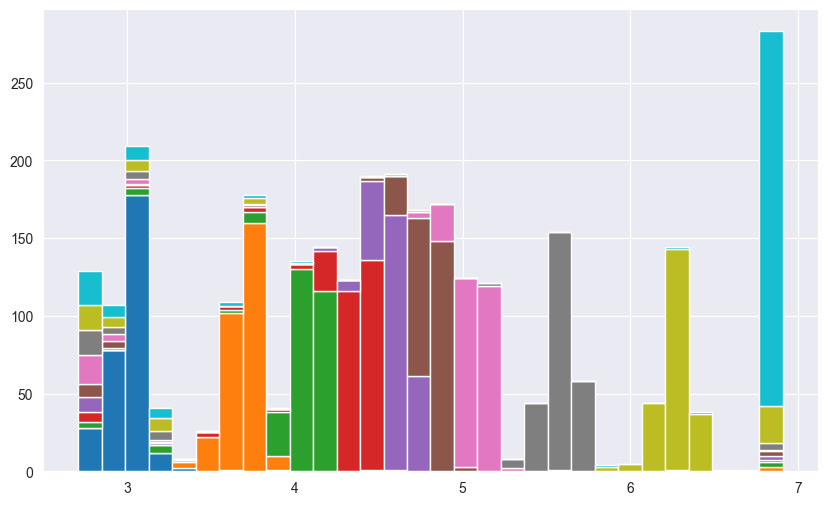

9

In [201]:
def find_bin(avg_dist):
    return np.digitize(logaritmare(avg_dist),bins)

def logaritmare(x):
    if x==0:
        x=1000
    return math.log(x)

vfunc = np.vectorize(logaritmare)

X=[np.array(vfunc(x)) for x in quality_peak_list]

# original_values = np.array(vfunc(uncompressed_data))
# high_values = np.array(vfunc(quality_high))
# medium_values = np.array(vfunc(quality_medium))
# low_values = np.array(vfunc(quality_low))
# 
# X=[original_values,high_values,medium_values,low_values]

plt.figure(figsize=(10, 6))

nb,bins,_ = plt.hist(X,bins=30, stacked=True ,histtype='bar',cumulative=False)

#floating point error: when an image gets a value exactly at the boundary, floating point precision might cause it to overshoot the bin
bins[-1]+=1
bins[0]-=1

print(nb)
print(bins)

#plt.hist(original_values,density=True, histtype='bar', stacked=True)
#plt.hist(high_values,density=True, histtype='bar', stacked=True)
#plt.hist(medium_values,density=True, histtype='bar', stacked=True)
#plt.hist(low_values,density=True, histtype='bar', stacked=True)
plt.title("Logarithmic distribution")
plt.xlabel("")
plt.ylabel("")
plt.show()


def most_likely_category(avg_dist):
    # when I get a new image see which bin it is in
    # P(cat1| bin x) = P(binx|cat1)*P(cat1) / P(binx)
    # greatest prob wins
    # p1 = nr_binx_cat1/nr_cat1 * nr_cat1/ nr_all_cat / nr_binx_total * nr_all_cat
    # p1 = nr_binx_cat1/nr_binx_total
    # since nr_binx_total is the same for all probabilities, we can just compare the number of images in each bin
    bin=find_bin(avg_dist)
    candidate_bin = nb[0][bin-1]
    ind=0
    for i in range(1,10):
        if nb[i][bin-1]-nb[i-1][bin-1] > candidate_bin:
            candidate_bin = nb[i][bin-1]-nb[i-1][bin-1]
            ind=i
    return ind+1
    
most_likely_category(400)

In [202]:
correct_predictions = 0
number_of_tests = 400
testing_cutoff = 700 # images from 700 onwards are for testing

error=0

for i in range(0, number_of_tests//4):
        for j in range(1, 5):
            
            file_name = f"{testing_cutoff + i + 1:04}x4w{j}.png"
            path = os.path.join("DIV2K_train_LR_wild", file_name)
            
            qual_cat = np.random.randint(1,11)
        
            img = compress(path, qual_cat*10)
            img = img.convert('YCbCr')
            img = zero_pad(np.array(img)[:,:,0])
            img = img.astype(np.float64)
            dct = DCT(img)[0,0,:]
            hcount, bin_edges = hist(dct)
            fft = FFT(hcount)
            _, avg_peak_dist,_ = quality(fft)
            print(avg_peak_dist)
            cat=most_likely_category(avg_peak_dist)
            print(qual_cat*10, cat*10)
            error += np.abs(cat*10-qual_cat*10)
            
            
print(f"average error: {error / number_of_tests} ")


def test_random_image(image_name):
    img = Image.open(image_name)
    img = img.convert('YCbCr')
    img = zero_pad(np.array(img)[:,:,0])
    img = img.astype(np.float64)
    dct = DCT(img)[0,0,:]
    hcount, bin_edges = hist(dct)
    fft = FFT(hcount)
    _, avg_peak_dist,_ = quality(fft)
    cat=most_likely_category(avg_peak_dist)
    print(f"{cat*10}% estimated compression level")

568
90 90
106
50 50
60
30 30
43
20 20
92
50 40
40
20 20
0
100 100
271
80 80
45
20 20
22
10 10
89
40 40
62
30 30
16
10 10
61
40 30
96
60 50
123
70 60
75
40 40
225
80 80
144
70 70
36
20 20
84
40 40
44
20 20
0
100 100
126
60 60
540
90 90
54
30 30
268
80 80
148
70 70
22
10 10
304
80 80
132
60 60
43
20 20
35
20 20
75
40 40
0
100 100
149
70 70
126
60 60
129
60 60
123
60 60
124
60 60
average error: 1.0 


In [199]:
print(bins)
print(np.digitize(logaritmare(0),bins))
print(logaritmare(0))

[1.77258872 2.91042761 3.04826649 3.18610538 3.32394426 3.46178315
 3.59962203 3.73746092 3.8752998  4.01313869 4.15097757 4.28881646
 4.42665534 4.56449423 4.70233312 4.840172   4.97801089 5.11584977
 5.25368866 5.39152754 5.52936643 5.66720531 5.8050442  5.94288308
 6.08072197 6.21856085 6.35639974 6.49423862 6.63207751 6.76991639
 7.90775528]
30
6.907755278982137
